In [130]:
import halotools
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
%matplotlib inline


In [131]:
from halotools import sim_manager
from halotools.sim_manager import CachedHaloCatalog
halocat = CachedHaloCatalog(simname = 'bolplanck', halo_finder = 'rockstar', redshift = 0)
halocat = CachedHaloCatalog(fname="/home/fas/vandenbosch/tpp28/.astropy/cache/halotools/halo_catalogs/bolplanck/rockstar/hlist_1.00231.list.halotools_v0p4.hdf5",update_cached_fname=True)

We begin with the analysis of a subsample of the Bolshoi simulation with Planck cosmology as of 2013
(h=0.7, $\Omega_{\Lambda}$=0.69289, $\Omega_{m}$ = 0.30711, $\Omega_b$ = 0.048, $n_s$ =  0.96, $\sigma_8$ = 0.82).
The simulation started at $z_{ini}$ = 80 and followed $2048^3$ particles of mass $M_{dm} = 1.55 \times 10^8$ $M_{sun}/h$ in their evolution in a volume of boxsize L=250 Mpc/h.


In [132]:
#Catalog of halos itself
halos = halocat.halo_table
#To see what properties are available 
print(halos.keys())
halocat.processing_notes

['halo_vmax_firstacc', 'halo_dmvir_dt_tdyn', 'halo_macc', 'halo_scale_factor', 'halo_vmax_mpeak', 'halo_m_pe_behroozi', 'halo_delta_vmax_behroozi17', 'halo_xoff', 'halo_spin', 'halo_tidal_force', 'halo_scale_factor_firstacc', 'halo_c_to_a', 'halo_mvir_firstacc', 'halo_scale_factor_last_mm', 'halo_tidal_id', 'halo_scale_factor_mpeak', 'halo_pid', 'halo_m500c', 'halo_id', 'halo_halfmass_scale_factor', 'halo_upid', 'halo_t_by_u', 'halo_rvir', 'halo_vpeak', 'halo_dmvir_dt_100myr', 'halo_mpeak', 'halo_m_pe_diemer', 'halo_jx', 'halo_jy', 'halo_jz', 'halo_m2500c', 'halo_mvir', 'halo_voff', 'halo_axisA_z', 'halo_axisA_x', 'halo_axisA_y', 'halo_y', 'halo_b_to_a', 'halo_x', 'halo_z', 'halo_m200b', 'halo_vacc', 'halo_scale_factor_lastacc', 'halo_vmax', 'halo_m200c', 'halo_vx', 'halo_vy', 'halo_vz', 'halo_dmvir_dt_inst', 'halo_tidal_force_tdyn', 'halo_rs', 'halo_nfw_conc', 'halo_hostid', 'halo_mvir_host_halo']


b'Catalog only contains (sub)halos with Mpeak greater than 300 particles. The following columns have been divided by 1000 to convert them from the kpc/h units provided in the original ASCII source to the Mpc/h units assumed by Halotools:  halo_rvir, halo_rs, halo_xoff'

2) Organize the data into samples
==

In [133]:
from halotools.utils import group_member_generator
#Group halos by halo host id
halos.sort('halo_hostid')
grouping_key = 'halo_hostid'
requested_columns = []
group_gen = group_member_generator(halos, grouping_key, requested_columns)

#calculates the number of subalos per host
nsub = np.zeros(len(halos))
for first, last, member_props in group_gen:
    nsub[first:last] = last - first - 1
#Adds a new column to the ith-row of the table which gives the number of subhalos found in the i-th halo
halos['num_subhalos'] = nsub

In [134]:
NumberHosthalos=0
NumberSubhalos=0
for i in range(0,len(halos)):
    if halos["halo_pid"][i]==-1:
        NumberHosthalos= NumberHosthalos+1
    else:
        NumberSubhalos = NumberSubhalos+1
        
print("Number of halos in total, unfilterd bolplank catalog", len(halos))
print("Number of hosthalos, unfilterd bolplank catalog", NumberHosthalos)
print("Number of subhalos, unfilterd bolplank catalog", NumberSubhalos)

Number of halos in total, unfilterd bolplank catalog 1444262
Number of hosthalos, unfilterd bolplank catalog 1078614
Number of subhalos, unfilterd bolplank catalog 365648


The catalog is filtered by the following criteria.
We generate two samples :

Sample 1 consists of all host halos with $M_{vir} < 10^{15} M_{sun}$ and with $M_{vir}/M_{Dm, partcl} > 100$ together with the subhalos  with $M_{vir}/M_{Dm, partcl} > 100$, $M_{vir}/M_{Vir, Host} > 10^{-3}$ and with $M_{Vir, Host} < 10^{15} M_{sun}$.

Sample 2 is constrained under the same criteria as Sample 1, but one of the conditions on the subhalos, namely $M_{vir}/M_{Vir, Host} > 10^{-3}$, is removed.

In [135]:
##We consider two main samples:
##Sample 1: Consider all halos consisting of more than 100 dm particles and exclude hosts with less than 10^15 solar masses
##Sample 2: Take into account all halos and still exclude hosts with less than 10^15 solar masses
#The mask for the hosts
M_dm_particle = 1.55e8
host_maskSample1 = ((halos['halo_upid'] == -1) & (halos["halo_mvir"]<1e15) & (halos["halo_mvir"]/M_dm_particle > 100))


hostsSample1 = halos[host_maskSample1]


#mask for the subhalos

sub_maskSample1 = ((halos["halo_upid"]>0)&((halos['halo_mvir']/halos["halo_mvir_host_halo"] > 1e-3))&(halos["halo_mvir_host_halo"]< 1e15)& (halos["halo_mvir"]/M_dm_particle > 100))

subsSample1 = halos[sub_maskSample1]
sub_maskSample2 = ((halos["halo_upid"]>0)&(halos["halo_mvir_host_halo"]< 1e15)& (halos["halo_mvir"]/M_dm_particle > 100))
subsSample2 = halos[sub_maskSample2]

print("Number of hosthalos in Sample 1 = ", len(hostsSample1))
print("The mean concentration of host halos in sample 1 is  ", "r$ \bar{c}$ = ", np.mean(hostsSample1['halo_nfw_conc']))
print("Number of subhalos in Sample 1 = ", len(subsSample1))
print("Number of subhalos in Sample 2 = ", len(subsSample2))



Number of hosthalos in Sample 1 =  1071702
The mean concentration of host halos in sample 1 is   r$ ar{c}$ =  16.079874
Number of subhalos in Sample 1 =  224818
Number of subhalos in Sample 2 =  289020


In [136]:
#Reduce subhalo set:
masktest = (subsSample1["halo_upid"]==subsSample1["halo_hostid"])
subsSample1 = subsSample1[masktest]
masktest2 = (subsSample2["halo_upid"]==subsSample2["halo_hostid"])
subsSample2 = subsSample2[masktest2]
print("Number of Subs in Sample 2", len(subsSample2))
print("Number of Subs in Sample 1", len(subsSample1))
#=> This didnt change anything in the sample, can therefore be omitted completely !

#Concentrate only on those hosts who actually have a subhalo
HostMaskTest = hostsSample1["num_subhalos"]>0
HostsWithSub = hostsSample1[HostMaskTest]
print("Number of Hosts", len(HostsWithSub))

Number of Subs in Sample 2 289020
Number of Subs in Sample 1 224818
Number of Hosts 109863


Go into Center of Mass Frame of respective Hosthalo
-----

In [137]:
#Average over mass and radial bin

#Consider only those hosts with 10^{12} M_{sun}/h <= M_{host} <= 10^{14} M_{sun}/h => Number of hosts available = 50374
HostsWithSub = HostsWithSub[(HostsWithSub["halo_mvir"]>1e13)&(HostsWithSub["halo_mvir"]<1e14)]

def IndexReturn(x):
    for m in range(0, len(HostsWithSub)):
        if x==HostsWithSub["halo_id"][m]:
            return m
        else:
            continue
            


#Loop to add another colum to sub where with the index position of the host halo
#subsSample1.add_column(subsSample1["halo_hostid"], name="HostIndexPos")
for i in range(0, len(HostsWithSub)):
    for j in range(0, len(subsSample1)):
        if subsSample1["halo_upid"][j]==HostsWithSub["halo_id"][i]:
            subsSample1["HostIndexPos"][j] = i
        else:
            continue


In [138]:
#Crossmatch catalogs with new mass bin: Gives back indices of the astropy table where the same data is found
from halotools.utils import crossmatch
idx_table1, idx_table2 = crossmatch(subsSample1['halo_upid'], HostsWithSub["halo_id"])


#Go into center of mass from of respective host halos

subsSample1["halo_x"][idx_table1] = subsSample1["halo_x"][idx_table1] - HostsWithSub["halo_x"][idx_table2]
subsSample1["halo_y"][idx_table1] = subsSample1["halo_y"][idx_table1] - HostsWithSub["halo_y"][idx_table2]
subsSample1["halo_z"][idx_table1] = subsSample1["halo_z"][idx_table1]- HostsWithSub["halo_z"][idx_table2]

subsSample1["halo_vx"][idx_table1] = subsSample1["halo_vx"][idx_table1]- HostsWithSub["halo_vx"][idx_table2]
subsSample1["halo_vy"][idx_table1]= subsSample1["halo_vy"][idx_table1]- HostsWithSub["halo_vy"][idx_table2]
subsSample1["halo_vz"][idx_table1]= subsSample1["halo_vz"][idx_table1]- HostsWithSub["halo_vz"][idx_table2]


idx_table1S2, idx_table2S2 = crossmatch(subsSample2['halo_upid'], HostsWithSub["halo_id"])

#Go into center of mass from of respective host halos
#Positions are given in Mpc/h, whilst velocities are given in m/s/h, thus Conv_m_Mpc makes velocity units to Mp/s/h

subsSample2["halo_x"][idx_table1S2] = subsSample2["halo_x"][idx_table1S2] - HostsWithSub["halo_x"][idx_table2S2]
subsSample2["halo_y"][idx_table1S2] = subsSample2["halo_y"][idx_table1S2] - HostsWithSub["halo_y"][idx_table2S2]
subsSample2["halo_z"][idx_table1S2] = subsSample2["halo_z"][idx_table1S2]- HostsWithSub["halo_z"][idx_table2S2]

subsSample2["halo_vx"][idx_table1S2] = subsSample2["halo_vx"][idx_table1S2]- HostsWithSub["halo_vx"][idx_table2S2]
subsSample2["halo_vy"][idx_table1S2]= subsSample2["halo_vy"][idx_table1S2]- HostsWithSub["halo_vy"][idx_table2S2]
subsSample2["halo_vz"][idx_table1S2] = subsSample2["halo_vz"][idx_table1S2] - HostsWithSub["halo_vy"][idx_table2S2]

#put every host halo system in origin 

HostsWithSub['halo_x'] = 0
HostsWithSub['halo_y'] = 0
HostsWithSub['halo_z'] = 0

HostsWithSub_s1 = HostsWithSub[idx_table2]
HostsWithSub_s2 = HostsWithSub[idx_table2S2]
subsSample1 = subsSample1[idx_table1]
subsSample2 = subsSample2[idx_table1S2]
sx1 = subsSample1["halo_x"]
sy1 = subsSample1["halo_y"]
sz1 = subsSample1["halo_z"]

sx2 = subsSample2["halo_x"]
sy2 = subsSample2["halo_y"]
sz2 = subsSample2["halo_z"]

svx1=subsSample1["halo_vx"]
svy1=subsSample1["halo_vy"]
svz1=subsSample1["halo_vz"]
svx2=subsSample2["halo_vx"]
svy2=subsSample2["halo_vy"]
svz2=subsSample2["halo_vz"]


In [139]:
print(np.mean(subsSample1["halo_x"]),np.max(subsSample1["halo_x"]), np.min(subsSample1["halo_x"]))

0.07831562 249.97179 -249.77206


#Filter those out who do not make physical sense



subsSample1=subsSample1[(subsSample1["halo_x"] < 2)]
subsSample1=subsSample1[(subsSample1["halo_y"] < 2)]
subsSample1=subsSample1[(subsSample1["halo_z"] < 2)]

subsSample2=subsSample2[(subsSample2["halo_x"] < 2)]
subsSample2=subsSample2[(subsSample2["halo_y"] < 2)]
subsSample2=subsSample2[(subsSample2["halo_z"] < 2)] 



idx_table1, idx_table2 = crossmatch(subsSample1["halo_upid"], HostsWithSub["halo_id"])
idx_table1S2, idx_table2S2 = crossmatch(subsSample2["halo_upid"], HostsWithSub["halo_id"])




sx1 = subsSample1["halo_x"][idx_table1]
sy1 = subsSample1["halo_y"][idx_table1]
sz1 = subsSample1["halo_z"][idx_table1]

sx2 = subsSample2["halo_x"][idx_table1S2]
sy2 = subsSample2["halo_y"][idx_table1S2]
sz2 = subsSample2["halo_z"][idx_table1S2]

svx1=subsSample1["halo_vx"][idx_table1]
svy1=subsSample1["halo_vy"][idx_table1]
svz1=subsSample1["halo_vz"][idx_table1]
svx2=subsSample2["halo_vx"][idx_table1S2]
svy2=subsSample2["halo_vy"][idx_table1S2]
svz2=subsSample2["halo_vz"][idx_table1S2]
print(len(sx1))
HostsWithSub_s1 = HostsWithSub[idx_table2]
HostsWithSub_s2 = HostsWithSub[idx_table2S2]
subsSample1 = subsSample1[idx_table1]
subsSample2 = subsSample2[idx_table1S2]

In [140]:
#Go into spherical coordinates

r_s1 = np.sqrt(sx1**2+sy1**2+sz1**2) #in Mpc/h
r_s2 = np.sqrt(sx2**2+sy2**2+sz2**2) #in Mpc/h

th_s1=np.arccos(sz1/r_s1)
th_s2=np.arccos(sz2/r_s2)

phi_s1=np.arctan(sy1/sx1)
phi_s2=np.arctan(sy2/sx2)

vr_s1 = svx1*np.sin(th_s1)*np.cos(phi_s1)+svy1*np.sin(th_s1)*np.sin(phi_s1)+svz1*np.cos(th_s1)   
vr_s2 = svx2*np.sin(th_s2)*np.cos(phi_s2)+svy2*np.sin(th_s2)*np.sin(phi_s2)+svz2*np.cos(th_s2)     

vphi_s1 = -svx1*np.sin(phi_s1)+svy1*np.cos(phi_s1)                 
vphi_s2 = -svx2*np.sin(phi_s2)+svy2*np.cos(phi_s2)                  

vth_s1 = svx1*np.cos(th_s1)*np.cos(phi_s1)+svy1*np.cos(th_s1)*np.sin(phi_s1)-svz1*np.sin(th_s1)      
vth_s2 = svx2*np.cos(th_s2)*np.cos(phi_s2)+svy2*np.cos(th_s2)*np.sin(phi_s2)-svz2*np.sin(th_s2)    


Dummy_s1 = subsSample1
Dummy_s1["halo_x"] = r_s1
Dummy_s1["halo_y"] = vr_s1
Dummy_s1["halo_z"] = vphi_s1
Dummy_s1["halo_vx"] = vth_s1
Dummy_s2 = subsSample2
Dummy_s2["halo_x"] = r_s2
Dummy_s2["halo_y"] = vr_s2
Dummy_s2["halo_z"] = vphi_s2
Dummy_s2["halo_vx"] = vth_s2

Dummy_s1 = Dummy_s1[Dummy_s1["halo_x"]<2]
Dummy_s2 = Dummy_s2[Dummy_s2["halo_x"]<2]
idx_table1, idx_table2 = crossmatch(Dummy_s1["halo_upid"], HostsWithSub["halo_id"])
idx_table1S2, idx_table2S2 = crossmatch(Dummy_s2["halo_upid"], HostsWithSub["halo_id"])

r_s1 = Dummy_s1["halo_x"][idx_table1]
r_s2 = Dummy_s2["halo_x"][idx_table1S2]
vr_s1 = Dummy_s1["halo_y"][idx_table1]
vphi_s1 = Dummy_s1["halo_z"][idx_table1]
vth_s1 = Dummy_s1["halo_vx"][idx_table1]
vr_s2 = Dummy_s2["halo_y"][idx_table1S2]
vphi_s2 =Dummy_s2["halo_z"][idx_table1S2]
vth_s2 = Dummy_s2["halo_vx"][idx_table1S2]

HostsWithSub_s1 = HostsWithSub[idx_table2]
HostsWithSub_s2 = HostsWithSub[idx_table2S2]
subsSample1 = subsSample1[idx_table1]
subsSample2 = subsSample2[idx_table1S2]


In [141]:
#calculate virial velocity to devide by: V_{Vir} = \\sqrt{\\frac{G M_{vir}}{r_{vir}}}\n",
NewGravConst = 6.671e-11*2e30/0.7 #in Units of solar mass\n",
VvirHost_s1 = np.sqrt(NewGravConst*HostsWithSub_s1["halo_mvir"]/(HostsWithSub_s1["halo_rvir"]*3.0857e25/0.7))

VvirHost_s2 = np.sqrt(NewGravConst*HostsWithSub_s2["halo_mvir"]/(HostsWithSub_s2["halo_rvir"]*3.0857e25/0.7))
#Vir velocity is now in units m/s\n"

In [142]:
from halotools.empirical_models import NFWProfile
nfw = NFWProfile()
V_vir_s1 = nfw.virial_velocity(HostsWithSub_s1["halo_mvir"])
V_vir_s2 = nfw.virial_velocity(HostsWithSub_s2["halo_mvir"])


In [143]:
print("rad", np.mean(r_s1), np.mean(r_s2),np.min(r_s1), np.min(r_s2), np.max(r_s1), np.max(r_s2), len(r_s1), len(r_s2))
print("vr", np.mean(vr_s1),np.mean(vr_s2),np.min(vr_s1), np.min(vr_s2), np.max(vr_s1), np.max(vr_s2), len(vr_s1), len(vr_s2))
print("vph", np.mean(vphi_s1),np.mean(vphi_s2),np.min(vphi_s1), np.min(vphi_s2), np.max(vphi_s1), np.max(vphi_s2), len(vphi_s1), len(vphi_s2))
print("vth", np.mean(vth_s1), np.mean(vth_s2),np.min(vth_s1), np.min(vth_s2), np.max(vth_s1), np.max(vth_s2), len(vth_s1), len(vth_s2))
print("V_vir", np.min(V_vir_s1), np.min(V_vir_s2), np.max(V_vir_s1), np.max(V_vir_s2))

rad 0.83087415 0.8080113 0.0010425296 0.0010425296 249.99239 249.99239 66683 93505
vr -22.886232 -21.623743 -1971.6361 -2284.5288 1710.8655 2524.4082 66683 93505
vph 1.2771639 0.21351753 -1646.5061 -1646.5061 2610.073 2610.073 66683 93505
vth -0.5750496 -4.1794686 -1703.2726 -2452.5984 1782.192 2499.1372 66683 93505
V_vir 311.18356 311.18356 669.7319 669.7319


In [144]:
#Go to dimensionless quantities with using correct unit conversion
Mpc_m_conv = 3.0857e25/0.7

vr_s1_norm = vr_s1/V_vir_s1
vphi_s1_norm = vphi_s1/V_vir_s1
vth_s1_norm = vth_s1/V_vir_s1
    
vr_s2_norm = vr_s2/V_vir_s2 
vphi_s2_norm = vphi_s2/V_vir_s2
vth_s2_norm = vth_s2/V_vir_s2

           
r_s1_norm =r_s1/HostsWithSub_s1["halo_rvir"]
r_s2_norm =r_s2/HostsWithSub_s2["halo_rvir"]



In [145]:
print("rad", np.mean(r_s1_norm), np.mean(r_s2_norm),np.min(r_s1_norm), np.min(r_s2_norm), np.max(r_s1_norm), np.max(r_s2_norm), len(r_s1_norm), len(r_s2_norm))
print("vr", np.mean(vr_s1_norm),np.mean(vr_s2_norm),np.min(vr_s1_norm), np.min(vr_s2_norm), np.max(vr_s1_norm), np.max(vr_s2_norm), len(vr_s1_norm), len(vr_s2_norm))
print("vph", np.mean(vphi_s1_norm),np.mean(vphi_s2_norm),np.min(vphi_s1_norm), np.min(vphi_s2_norm), np.max(vphi_s1_norm), np.max(vphi_s2_norm), len(vphi_s1_norm), len(vphi_s2_norm))
print("vth", np.mean(vth_s1_norm), np.mean(vth_s2_norm),np.min(vth_s1_norm), np.min(vth_s2_norm), np.max(vth_s1_norm), np.max(vth_s2_norm), len(vth_s1_norm), len(vth_s2_norm))


rad 1.3863615 1.2684549 0.0013728585 0.0013728585 568.7115 568.7115 66683 93505
vr -0.054178614 -0.04864395 -6.1947675 -5.6724024 3.680013 6.245148 66683 93505
vph 0.0025279387 0.0005735208 -4.5372477 -4.5372477 5.704112 5.704112 66683 93505
vth -0.0009737689 -0.009534959 -4.566661 -7.167255 3.9202433 6.245204 66683 93505


In [146]:
#Average over quantities
aver_vr_s2_raw = 0
aver_vth_s2_raw = 0
aver_vph_s2_raw = 0
aver_vr_s1_raw = 0
aver_vth_s1_raw = 0
aver_vph_s1_raw = 0
aver_vr2_s2_raw = 0
aver_vth2_s2_raw = 0
aver_vph2_s2_raw = 0
aver_vr2_s1_raw = 0
aver_vth2_s1_raw = 0
aver_vph2_s1_raw = 0
aver_vrvth_s1_raw = 0
aver_vrvth_s2_raw = 0
aver_vrvphi_s1_raw = 0
aver_vrvphi_s2_raw = 0
aver_vphivth_s1_raw = 0
aver_vphivth_s2_raw = 0

number_raw_s2 = 0
number_raw_s1 = 0
aver_m_s2_raw = 0
aver_m_s1_raw = 0
aver_vrad_s1 = np.array([])
aver_vrad_s2 = np.array([])
aver_vphi_s1 = np.array([])
aver_vphi_s2 = np.array([])
aver_vth_s1  = np.array([])
aver_vth_s2  = np.array([])

aver_vrvth_s1= np.array([])
aver_vrvth_s2= np.array([])
aver_vrvphi_s1= np.array([])
aver_vrvphi_s2= np.array([])
aver_vphivth_s1= np.array([])
aver_vphivth_s2= np.array([])

aver_vrad2_s1 = np.array([])
aver_vrad2_s2 = np.array([])
aver_vphi2_s1 = np.array([])
aver_vphi2_s2 = np.array([])
aver_vth2_s1  = np.array([])
aver_vth2_s2  = np.array([])

aver_m_s2 = np.array([])
N_sub_s2 = np.array([])
aver_m_s1 = np.array([])
N_sub_s1 = np.array([])



r_values = np.linspace(0,1,30)
#r_values = np.array([0,0.1,0.3,0.5,0.7,0.9,1])

 
for j in range(0, len(r_values)-1):
    
    for i in range(0, len(subsSample1)-1):
    
        if (r_values[j]< r_s1_norm[i] < r_values[j+1]):
            
            aver_vr_s1_raw = aver_vr_s1_raw + vr_s1_norm[i]
            aver_vth_s1_raw = aver_vth_s1_raw + vth_s1_norm[i]
            aver_vph_s1_raw = aver_vph_s1_raw + vphi_s1_norm[i]
            aver_vr2_s1_raw = aver_vr2_s1_raw + vr_s1[i]**2
            aver_vth2_s1_raw = aver_vth2_s1_raw + vth_s1[i]**2
            aver_vph2_s1_raw = aver_vph2_s1_raw + vphi_s1[i]**2
            aver_vrvth_s1_raw = aver_vrvth_s1_raw + vr_s1[i]*vth_s1[i]
            aver_vrvphi_s1_raw = aver_vrvphi_s1_raw + vr_s1[i]*vphi_s1[i]
            aver_vphivth_s1_raw = aver_vphivth_s1_raw + vphi_s1[i]*vth_s1[i]
            
            aver_m_s1_raw = aver_m_s1_raw + subsSample1["halo_mvir"][i]
            number_raw_s1 = number_raw_s1 +1
        else:
            continue
            
    aver_vrad_s1= np.append(aver_vrad_s1, aver_vr_s1_raw/number_raw_s1)
    aver_vphi_s1= np.append(aver_vphi_s1, aver_vth_s1_raw/number_raw_s1)
    aver_vth_s1= np.append(aver_vth_s1, aver_vph_s1_raw/number_raw_s1)
    aver_vrad2_s1= np.append(aver_vrad2_s1, aver_vr2_s1_raw/number_raw_s1)
    aver_vphi2_s1= np.append(aver_vphi2_s1, aver_vth2_s1_raw/number_raw_s1)
    aver_vth2_s1= np.append(aver_vth2_s1, aver_vph2_s1_raw/number_raw_s1)
    aver_vrvth_s1= np.append(aver_vrvth_s1, aver_vrvth_s1_raw/number_raw_s1)
    aver_vrvphi_s1= np.append(aver_vrvphi_s1, aver_vrvphi_s1_raw/number_raw_s1)
    aver_vphivth_s1= np.append(aver_vphivth_s1, aver_vphivth_s1_raw/number_raw_s1)
    
    aver_m_s1 = np.append(aver_m_s1, aver_m_s1_raw/number_raw_s1)
    N_sub_s1 = np.append(N_sub_s1, number_raw_s1)
    aver_vr_s1_raw = 0
    aver_vth_s1_raw = 0
    aver_vph_s1_raw = 0
    number_raw_s1 = 0

    

In [147]:
aver_vth_s1

array([-0.00092147,  0.1006892 ,  0.01317558,  0.03390078,  0.00266793,
        0.05317068, -0.00288192, -0.00490732,  0.00297556, -0.00564609,
       -0.0044344 ,  0.00350127,  0.01314022, -0.00972061,  0.026485  ,
       -0.00203808,  0.01500407, -0.01151405, -0.00879029,  0.00789755,
       -0.00922918, -0.00711588,  0.00360487,  0.00229133, -0.00590644,
        0.00288303,  0.00098676,  0.00279765,  0.00170775])

In [148]:
for j in range(0, len(r_values)-1):
    
    for i in range(0, len(subsSample2)-1):
    
        if (r_values[j]< r_s2_norm[i] < r_values[j+1]):
            
            aver_vr_s2_raw = aver_vr_s2_raw + vr_s2_norm[i]
            aver_vth_s2_raw = aver_vth_s2_raw + vth_s2_norm[i]
            aver_vph_s2_raw = aver_vph_s2_raw + vphi_s2_norm[i]
            aver_vr2_s2_raw = aver_vr2_s2_raw + vr_s2[i]**2
            aver_vth2_s2_raw = aver_vth2_s2_raw + vth_s2[i]**2
            aver_vph2_s2_raw = aver_vph2_s2_raw + vphi_s2[i]**2
            aver_vrvth_s2_raw = aver_vrvth_s2_raw + vr_s2[i]*vth_s2[i]
            aver_vrvphi_s2_raw = aver_vrvphi_s2_raw + vr_s2[i]*vphi_s2[i]
            aver_vphivth_s2_raw = aver_vphivth_s2_raw + vphi_s2[i]*vth_s2[i]
  
            
            aver_m_s2_raw = aver_m_s2_raw + subsSample2["halo_mvir"][i]
            number_raw_s2 = number_raw_s2 +1
        else:
            continue
            
    aver_vrad_s2= np.append(aver_vrad_s2, aver_vr_s2_raw/number_raw_s2)
    aver_vphi_s2= np.append(aver_vphi_s2, aver_vth_s2_raw/number_raw_s2)
    aver_vth_s2= np.append(aver_vth_s2, aver_vph_s2_raw/number_raw_s2)
    aver_vrad2_s2= np.append(aver_vrad2_s2, aver_vr2_s2_raw/number_raw_s2)
    aver_vphi2_s2= np.append(aver_vphi2_s2, aver_vth2_s2_raw/number_raw_s2)
    aver_vth2_s2= np.append(aver_vth2_s2, aver_vph2_s2_raw/number_raw_s2)
    aver_m_s2 = np.append(aver_m_s2, aver_m_s2_raw/number_raw_s2)
    aver_vrvth_s2= np.append(aver_vrvth_s2, aver_vrvth_s2_raw/number_raw_s2)
    aver_vrvphi_s2= np.append(aver_vrvphi_s2, aver_vrvphi_s2_raw/number_raw_s2)
    aver_vphivth_s2= np.append(aver_vphivth_s2, aver_vphivth_s2_raw/number_raw_s2)
    N_sub_s2 = np.append(N_sub_s2, number_raw_s2)
    aver_vr_s2_raw = 0
    aver_vth_s2_raw = 0
    aver_vph_s2_raw = 0
    number_raw_s2 = 0
   

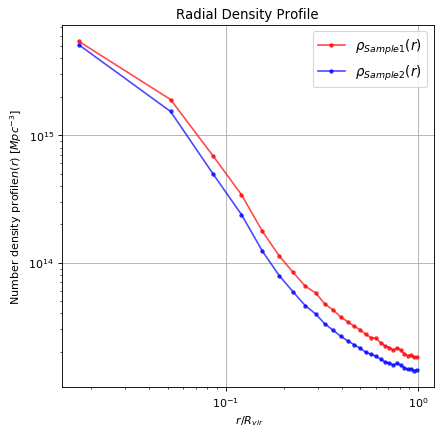

In [171]:
shell_volumes = 4/3*np.pi*(r_values[1:]**3-r_values[:-1]**3)
rbins_midpoints = (r_values[:-1] + r_values[1:])/2
from scipy.interpolate import CubicSpline

RhoInterpl_s1 = CubicSpline(rbins_midpoints, aver_m_s1/shell_volumes)
RhoInterpl_s2 = CubicSpline(rbins_midpoints, aver_m_s2/shell_volumes)
x_axis = np.linspace(0,1,10000)

# Create a new figure 
fig = plt.figure(figsize=(6,6), dpi=80)
plot_profile = fig.add_subplot(111)
plot_profile.set_xscale('log')
plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(0.001, 1e3)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'Number density profile$n(r) \;[Mpc^{-3}]$')

plot_profile.plot(rbins_midpoints, aver_m_s1/shell_volumes, color="red", marker=".",label=r"$\rho_{Sample 1}(r)$",alpha=0.7)
#plot_profile.plot(x_axis, RhoInterpl(x_axis), color="black", marker=".",label=r"$\rho_{Interplt}(r)$",alpha=0.5, lw=0.3)

plot_profile.plot(rbins_midpoints, aver_m_s2/shell_volumes, color="blue", marker=".",label=r"$\rho_{Sample 2}(r)$",alpha=0.7)


plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Radial Density Profile")
# Save figure using 80 dots per inch
plt.savefig("RadialDensityProfile.pdf",dpi=80)


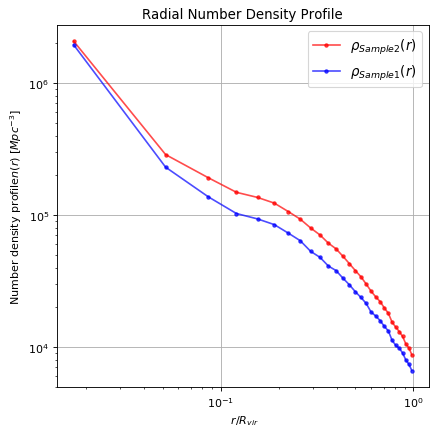

In [150]:

# Create a new figure 
fig = plt.figure(figsize=(6,6), dpi=80)
plot_profile = fig.add_subplot(111)
plot_profile.set_xscale('log')
plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(0.001, 1e3)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'Number density profile$n(r) \;[Mpc^{-3}]$')

plot_profile.plot(rbins_midpoints, N_sub_s2/shell_volumes, color="red", marker=".",label=r"$\rho_{Sample 2}(r)$",alpha=0.7)
plot_profile.plot(rbins_midpoints, N_sub_s1/shell_volumes, color="blue", marker=".",label=r"$\rho_{Sample 1}(r)$",alpha=0.7)


plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Radial Number Density Profile")
# Save figure using 80 dots per inch
plt.savefig("RadialNumberDensityProfile.pdf",dpi=80)


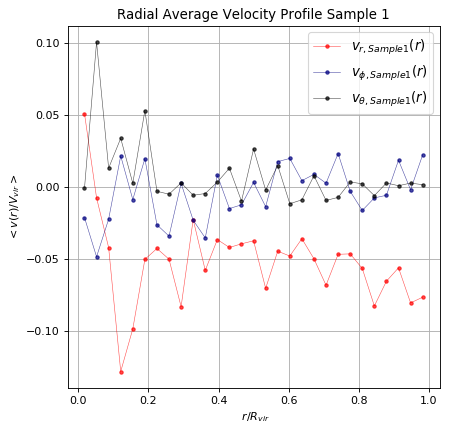

In [151]:
# Create a new figure 
fig = plt.figure(figsize=(6,6), dpi=80)
plot_profile = fig.add_subplot(111)
#plot_profile.set_xscale('log')
#plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(0.001, 1e3)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'$<v(r)/V_{vir}>$')
rbins_midpoints = (r_values[:-1] + r_values[1:])/2
plot_profile.plot(rbins_midpoints, aver_vrad_s1, color="red", marker=".",lw=0.5,label=r"$v_{r, Sample 1} (r)$",alpha=0.7)
plot_profile.plot(rbins_midpoints, aver_vphi_s1, color="navy", marker=".",lw=0.5,label=r"$v_{\phi, Sample 1} (r)$",alpha=0.7)
plot_profile.plot(rbins_midpoints, aver_vth_s1, color="black",lw=0.5,marker=".",label=r"$v_{\theta, Sample 1} (r)$", alpha=0.7)


plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Radial Average Velocity Profile Sample 1")
# Save figure using 80 dots per inch
plt.savefig("AverageRadialVelocityProfilesSample1.pdf",dpi=80)


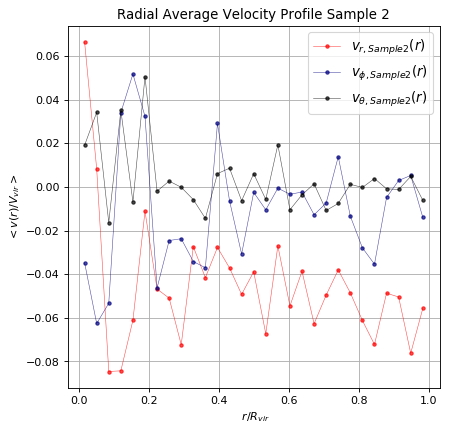

In [152]:
# Create a new figure 
fig = plt.figure(figsize=(6,6), dpi=80)
plot_profile = fig.add_subplot(111)
#plot_profile.set_xscale('log')
#plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(0.001, 1e3)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'$<v(r)/V_{vir}>$')
rbins_midpoints = (r_values[:-1] + r_values[1:])/2
plot_profile.plot(rbins_midpoints, aver_vrad_s2, color="red", marker=".",lw=0.5,label=r"$v_{r, Sample 2} (r)$",alpha=0.7)
plot_profile.plot(rbins_midpoints, aver_vphi_s2, color="navy", marker=".",lw=0.5,label=r"$v_{\phi, Sample 2} (r)$",alpha=0.7)
plot_profile.plot(rbins_midpoints, aver_vth_s2, color="black",lw=0.5,marker=".",label=r"$v_{\theta, Sample 2} (r)$", alpha=0.7)


plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Radial Average Velocity Profile Sample 2")
# Save figure using 80 dots per inch
plt.savefig("AverageRadialVelocityProfilesSample2.pdf",dpi=80)


# Anisotropy Parameter

Use that $\sigma_i^2 := <v_i\, v_i> - <v_i>^2$

In [153]:
#Compute anisotropy parameter:

sigma2rS1  = aver_vrad2_s2 - aver_vrad_s1**2
sigma2rS2  = aver_vrad2_s2 - aver_vrad_s2**2
sigma2thS1 = aver_vth2_s1 - aver_vth_s1**2
sigma2thS2 = aver_vth2_s2 - aver_vth_s2**2
sigma2phiS1 = aver_vphi2_s1 - aver_vphi_s1**2 
sigma2phiS2 = aver_vphi2_s2 - aver_vphi_s2**2

beta_S1 = 1- (sigma2thS1+sigma2phiS1)/2/sigma2rS1
beta_S2 = 1- (sigma2thS2+sigma2phiS2)/2/sigma2rS2
#beta_phi_r_S1 = 1- sigma2phiS1/sigma2rS1
#beta_phi_r_S2 = 1- sigma2phiS2/sigma2rS2

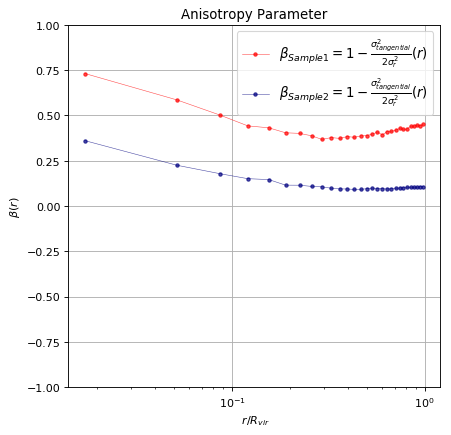

In [161]:
# Create a new figure 
fig = plt.figure(figsize=(6,6), dpi=80)
plot_profile = fig.add_subplot(111)
plot_profile.set_xscale('log')
#plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
plot_profile.set_ylim(-1, 1)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'$\beta (r)$')

plot_profile.plot(rbins_midpoints, beta_S1, color="red", marker=".",lw=0.5,label=r"$\beta_{Sample 1} = 1-\frac{\sigma^2_{tangential}}{2 \sigma^2_r} (r)$",alpha=0.7)
#plot_profile.plot(rbins_midpoints, beta_th_r_S2, color="navy", marker=".",lw=0.5,label=r"$\beta = 1-\frac{\sigma^2_{\phi}}{\sigma^2_r} (r)$",alpha=0.7)
plot_profile.plot(rbins_midpoints, beta_S2, color="navy", marker=".",lw=0.5,label=r"$\beta_{Sample 2} = 1-\frac{\sigma^2_{tangential}}{2 \sigma^2_r} (r)$",alpha=0.7)

plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Anisotropy Parameter")
# Save figure using 80 dots per inch
plt.savefig("AnisotropyParameter.pdf",dpi=80)


# Average Velocity Dispersion Profile

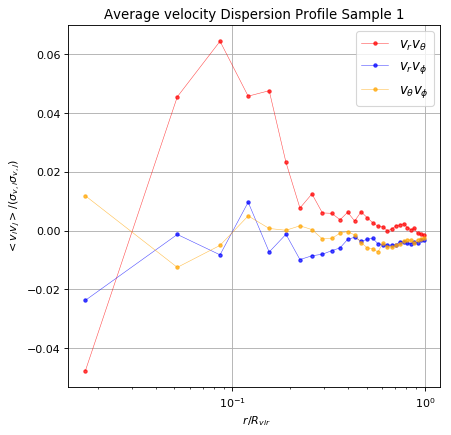

In [156]:
# Create a new figure 
fig = plt.figure(figsize=(6,6), dpi=80)
plot_profile = fig.add_subplot(111)
plot_profile.set_xscale('log')
#plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(-1, 1)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'$<v_i v_j>/(\sigma_{v,i} \sigma_{v,j})$')

plot_profile.plot(rbins_midpoints, aver_vrvth_s1/np.sqrt(sigma2rS1)/np.sqrt(sigma2thS1), color="red", marker=".",lw=0.5,label=r"$v_r v_{\theta}$",alpha=0.7)
plot_profile.plot(rbins_midpoints, aver_vrvphi_s1/np.sqrt(sigma2rS1)/np.sqrt(sigma2phiS1), color="blue", marker=".",lw=0.5,label=r"$v_r v_{\phi}$",alpha=0.7)
plot_profile.plot(rbins_midpoints, aver_vphivth_s1/np.sqrt(sigma2phiS1)/np.sqrt(sigma2thS1), color="orange", marker=".",lw=0.5,label=r"$v_{\theta} v_{\phi}$",alpha=0.7)

#/ShellVolume/float(len(firstGenSubsSample1Test[idx_table1]))

plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Average velocity Dispersion Profile Sample 1")
# Save figure using 80 dots per inch
plt.savefig("AverageVelocityDispersionProfileSample1.pdf",dpi=80)


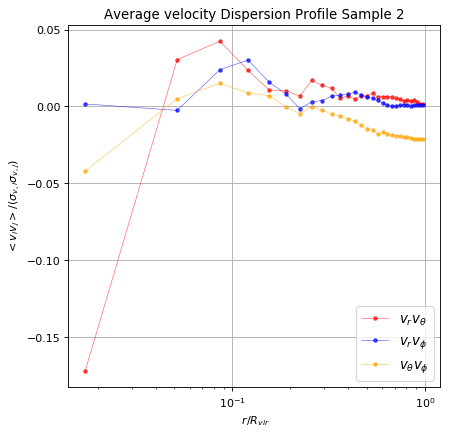

In [157]:
# Create a new figure 
fig = plt.figure(figsize=(6,6), dpi=80)
plot_profile = fig.add_subplot(111)
plot_profile.set_xscale('log')
#plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(-1, 1)

plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'$<v_i v_j>/(\sigma_{v,i} \sigma_{v,j})$')

plot_profile.plot(rbins_midpoints, aver_vrvth_s2/np.sqrt(sigma2rS2)/np.sqrt(sigma2thS2), color="red", marker=".",lw=0.5,label=r"$v_r v_{\theta}$",alpha=0.7)
plot_profile.plot(rbins_midpoints, aver_vrvphi_s2/np.sqrt(sigma2rS2)/np.sqrt(sigma2phiS2), color="blue", marker=".",lw=0.5,label=r"$v_r v_{\phi}$",alpha=0.7)
plot_profile.plot(rbins_midpoints, aver_vphivth_s2/np.sqrt(sigma2phiS2)/np.sqrt(sigma2thS2), color="orange", marker=".",lw=0.5,label=r"$v_{\theta} v_{\phi}$",alpha=0.7)

#/ShellVolume/float(len(firstGenSubsSample1Test[idx_table1]))

plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Average velocity Dispersion Profile Sample 2")
# Save figure using 80 dots per inch
plt.savefig("AverageVelocityDispersionProfileSample2.pdf",dpi=80)


# Radial Velocity Distribution Profile, integrated solution with Beta= const.

In a NFW halo, the gravitational potential is given by:
    $    \Phi (s)  =- V^2_{Vir} g(c) \frac{ln(1+c\,s)}{s} $ \\
    where
    $ g(c) = [ln(1+c)-\frac{c}{1+c}]^{-1}$, $s = r/r_{vir}$, 
    and $V^2_{Vir} = GM_{Vir}/r_{vir}$.

The Integrated solution of the Spherical Jeans equation reads for beta=const:


$\frac{\sigma_r^2 (r)}{V_{vir}^2} = - \frac{s^{-2 \beta}}{\rho (s)} \int_s^{\infty} \mathrm{d}q q^{2 \beta} \rho (q) g(c) \left[ \frac{c}{q(1+cq)} - \frac{ln(1+cq)}{q^{2}}\right]$

In [222]:
c_mean_s1 =np.int(np.mean(HostsWithSub_s1["halo_nfw_conc"]))
c_mean_s2 =np.int(np.mean(HostsWithSub_s2["halo_nfw_conc"]))
g_s1 = (np.log(1+c_mean_s1)-c_mean_s1/(1+c_mean_s1))**(-1)
g_s2 = (np.log(1+c_mean_s2)-c_mean_s2/(1+c_mean_s2))**(-1)
beta = 0.3

def Kernel_s1(q):
    return q**(2*beta) *RhoInterpl_s1(q)*g_s1 *(c_mean_s1/q/(1+c_mean_s1*q) - np.log(1+c_mean_s1*q)/q**2)
def Kernel_s2(q):
    return q**(2*beta) *RhoInterpl_s2(q)*g_s2 *(c_mean_s2/q/(1+c_mean_s2*q) - np.log(1+c_mean_s2*q)/q**2)

Kernel_s1 = lambda q: q**(2*beta) *RhoInterpl_s1(q)*g_s1 *(c_mean_s1/q/(1+c_mean_s1*q) - np.log(1+c_mean_s1*q)/q**2)
Kernel_s2 = lambda q: q**(2*beta) *RhoInterpl_s2(q)*g_s1 *(c_mean_s2/q/(1+c_mean_s2*q) - np.log(1+c_mean_s2*q)/q**2)

from scipy.integrate import quad

def RadialVelDisp_s1(s):
    return -s**(-2*beta)/RhoInterpl_s1(s) *quad(Kernel_s1, s, np.infty)[0]

def RadialVelDisp_s2(s):
    return -s**(-2*beta)/RhoInterpl_s2(s) *quad(Kernel_s2, s,np.infty)[0]

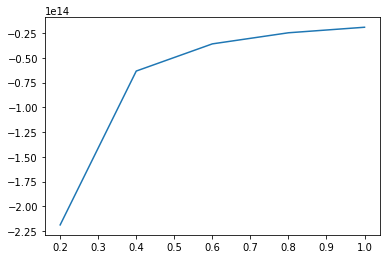

In [233]:
plt.plot(s,Kernel_s1(s))

In [227]:
test = np.array([])

s = np.array([0,0.2,0.4,0.6,0.8,1])
for i in range(0, len(s)):
    test = np.append(test, -s[i]**(-2*beta)/RhoInterpl_s2(s[i]) *quad(Kernel_s2, s[i],np.infty)[0])
    
    

/home/fas/vandenbosch/tpp28/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/home/fas/vandenbosch/tpp28/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  warnings.warn(msg, IntegrationWarning

In [212]:
print(quad(Kernel_s1, 0.1,np.infty))

(-6.866006460033635e+29, 1.3520080737951293e+30)


/home/fas/vandenbosch/tpp28/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


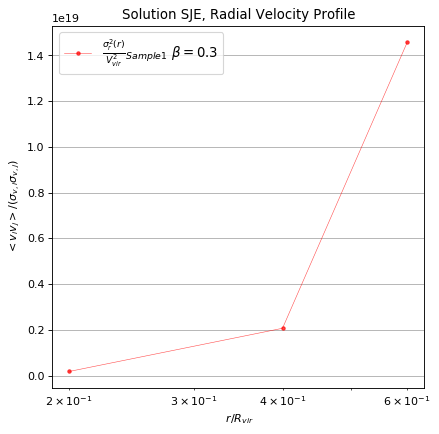

In [230]:
# Create a new figure 
fig = plt.figure(figsize=(6,6), dpi=80)
plot_profile = fig.add_subplot(111)
plot_profile.set_xscale('log')
#plot_profile.set_yscale('log')
plot_profile.grid(True)

#plot_ps.set_xlim(1.0e-5, 1.0e5)
#plot_profile.set_ylim(-1, 1)

    
plot_profile.set_xlabel(r' $ r/R_{vir} $')
plot_profile.set_ylabel(r'$<v_i v_j>/(\sigma_{v,i} \sigma_{v,j})$')

#plot_profile.plot(rbins_midpoints, RadialVelDisp_s1(rbins_midpoints), color="red", marker=".",lw=0.5,label=r"$\frac{\sigma_r^2 (r)}{V_{vir}^2}_{Sample 1}$ $\beta =0.3$",alpha=0.7)
#plot_profile.plot(rbins_midpoints, RadialVelDisp_s2(rbins_midpoints), color="blue", marker=".",lw=0.5,label=r"$\frac{\sigma_r^2 (r)}{V_{vir}^2}_{Sample 2}$ $\beta =0.3$",alpha=0.7)
plot_profile.plot(s[:-2], test[:-2], color="red", marker=".",lw=0.5,label=r"$\frac{\sigma_r^2 (r)}{V_{vir}^2}_{Sample 1}$ $\beta =0.3$",alpha=0.7)


plot_profile.legend(prop={'size':12}, loc="best")
plt.title("Solution SJE, Radial Velocity Profile")
# Save figure using 80 dots per inch
plt.savefig("SolutionSJEradialVelocityProfile.pdf",dpi=80)


6) Gravitational Potential
==============